In [70]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [71]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = '../lab10/MNIST/raw'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=64)
valid_dataloader = DataLoader(val_dataset, batch_size=64)

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [72]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
--2025-01-26 20:54:43--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: 'sample_photo.jpg'

sample_photo.jpg    100%[===================>]  48.18K   106KB/s    in 0.5s    

2025-01-26 20:54:46 (106 KB/s) - 'sample_photo.jpg' saved [49337/49337]



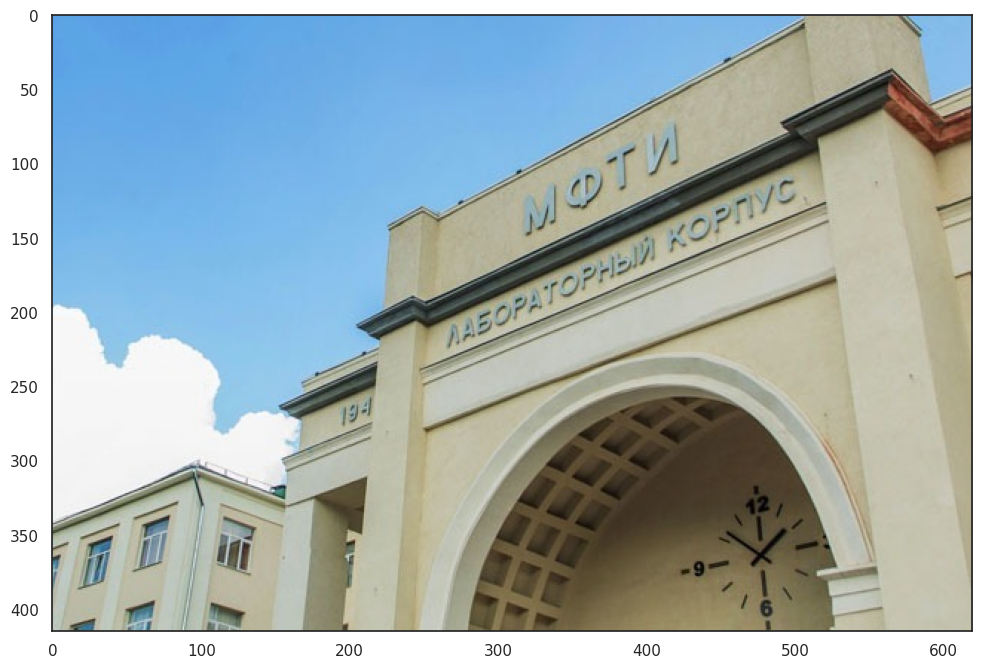

In [73]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [74]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
print(img_t.shape)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

torch.Size([1, 415, 620, 3])


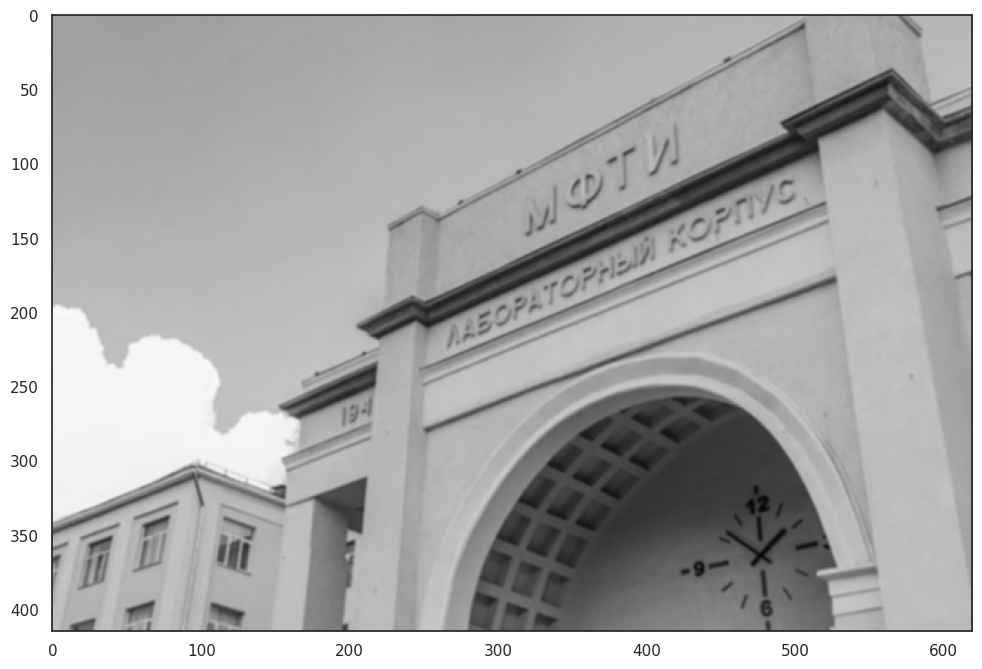

In [75]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие - Е

2) Увеличение резкости - Д

3) Тождественное преобразование - A

4) Выделение вертикальных границ - В

5) Выделение горизонтальных границ - Б

6) Выделение границ - Г

**Ответ:**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [76]:
from typing import Any


class LeNet(nn.Module):
    def __init__(self, act_func: Any):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Flatten()
        self.fc2 = nn.Linear(16 * 5 * 5, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 10)
        
        self.act_func = act_func

    def forward(self, x):
        x = self.act_func(self.conv1(x))
        x = self.pool1(x)
        x = self.act_func(self.conv2(x))
        x = self.pool2(x)

        x = self.fc1(x)
        x = self.act_func(self.fc2(x))
        x = self.act_func(self.fc3(x))
        x = self.fc4(x)
        
        return x


In [77]:
class Identical(nn.Module):
    def forward(self, x):
        return x


### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети
.

In [110]:
max_epochs = 10
        
def test_activation_function(act_func: Any) -> list:
    model = LeNet(act_func).to(device="cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    return train_with_accuracy(model=model, 
                               criterion=criterion, 
                               optimizer=optimizer, 
                               epochs=max_epochs)

def train_with_accuracy(model: nn.Module,
                        criterion: nn.Module,
                        optimizer: torch.optim.Optimizer,
                        epochs: int) -> list[float]:
    def train() -> None:
        model.train()
        for idx, (X_batch, y_batch) in enumerate(train_dataloader):
            optimizer.zero_grad()
            output = model.forward(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

    def valid() -> float:
        model.eval()
        matched_y = 0
        all_y = 0
        
        with torch.no_grad():
            for idx, (X_batch, y_batch) in enumerate(valid_dataloader):
                output = model.forward(X_batch)
                matched_y += (torch.max(output, 1).indices == y_batch).sum()
                all_y += len(y_batch)
                
        return matched_y / all_y

    accuracy = []

    for i in range(epochs):
        train()
        accuracy.append(valid())
        
    return accuracy


In [111]:
relu_accuracy = test_activation_function(nn.ReLU())
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())
elu_accuracy = test_activation_function(nn.ELU())
lenet_accuracy = test_activation_function(Identical())

In [113]:
elu_accuracy[-1]

tensor(0.9879)

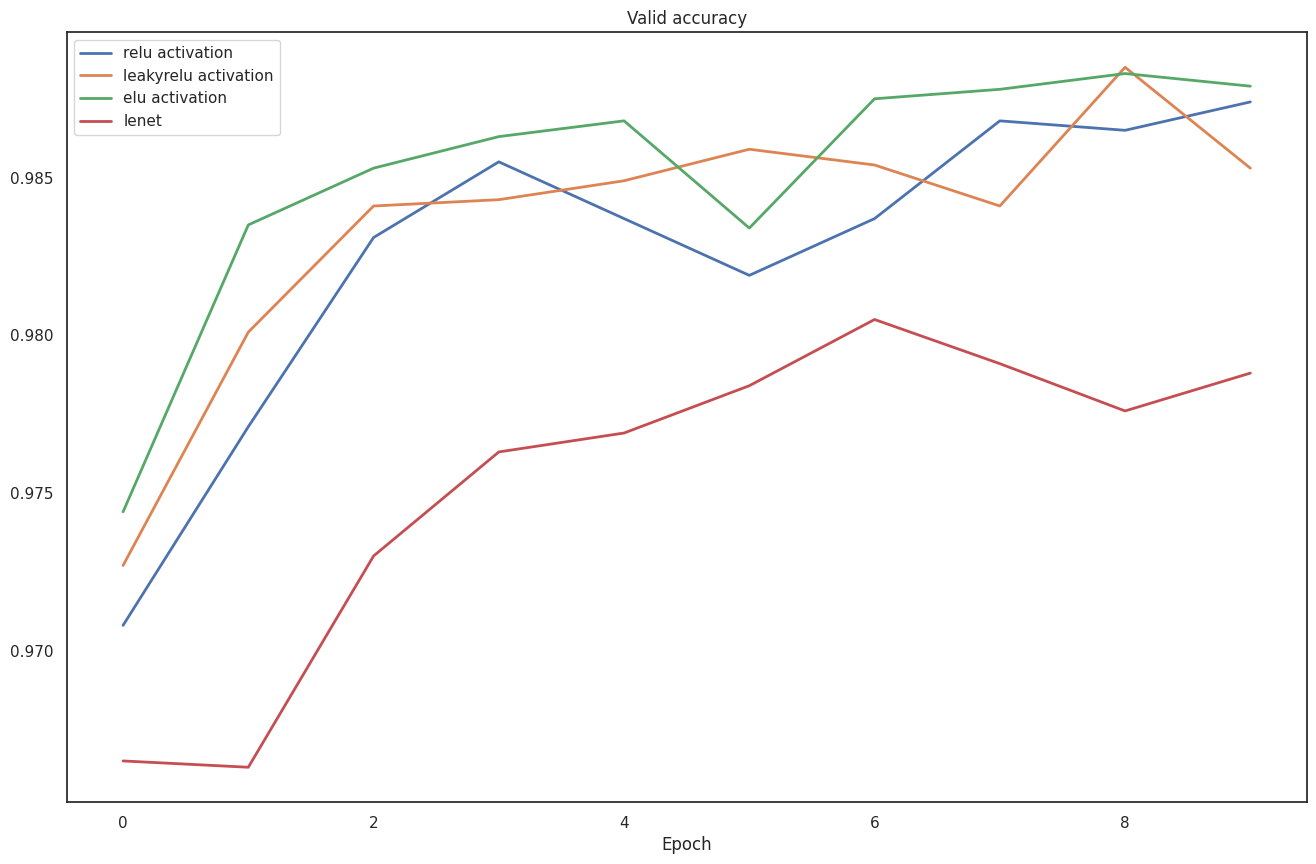

In [112]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="relu activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="leakyrelu activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="elu activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="lenet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()


**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99 (для ELU)